# Titanic Dataset

## Chapter 1 - EDA 

The goal 🎯 of this jupyter Notebook is to explore different machine learning or deep learning algorithms in order to obtain an accuracy score higher than 85% in the prediction of the people who survived or not in the titanic accident. Link to the exercise:
- [Link]([Link](https://www.kaggle.com/c/titanic))

### Needed library

In [8]:
#Pandas to work with Dataframe and numpy for array (np)
import pandas as pd
import numpy as np

#Seaborn and matplotlib for dataviz
import seaborn as sns
import matplotlib.pyplot as plt

#Machine learning library to make prediction, features transformation and results analysis
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

# Tensorflow for Deep learning
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import models

#Regex lib
import re

#Robust scaling
from sklearn.preprocessing import StandardScaler

import warnings 
warnings.filterwarnings('ignore')



### Dataset Information

In [12]:
# Load dataset
titanic_df = pd.read_csv("../input/titanic/train.csv")
# Show Dataset first line
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To check the description of different fields in this dataset :
>[Kaggle description of the dataset Link](https://www.kaggle.com/competitions/titanic/data)


In [14]:
# Describe data and get different information from this train dataset
titanic_describe = titanic_df.loc[:, titanic_df.columns != "PassengerId"].describe()
titanic_describe

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Deal 🥦 with missing values

In [15]:
# Check the nan value in the dataset
for column in titanic_df.columns:
    print(f"{column} as {titanic_df[column].isnull().sum()} nan values")

PassengerId as 0 nan values
Survived as 0 nan values
Pclass as 0 nan values
Name as 0 nan values
Sex as 0 nan values
Age as 177 nan values
SibSp as 0 nan values
Parch as 0 nan values
Ticket as 0 nan values
Fare as 0 nan values
Cabin as 687 nan values
Embarked as 2 nan values


As we can see, Age, Cabin and Embarked have Nan value. 



#### Work with age feature
We can check if age feature as a good correlation with the survived features.

In [16]:
# Get the importance of the Age features for the prediction of  Survived 
titanic_df[["Survived","Age"]].corr(method="pearson")

,Survived,Age
Survived,1.000000,-0.077221
Age,-0.077221,1.000000


This table tell us that we are a decrease correlation of 7% between Survived and Age 🙌🏼. 

Maybe we can use this  features in our futur model. But we have 177 missing features.

We can explore different strategies for the age feature: 
1. Fill age nan values by the mean or the median of the age distribution
2. Drop all nan values but the dataset is small and 177 rows is a lot in this context
3. Maybe try to find classes in age for who survived the most
4. Delete the age features

I decide to apply the first and third strategy

Let's see the Distribution of age by sex:

[Text(0.5, 1.0, 'Age By Sex')]

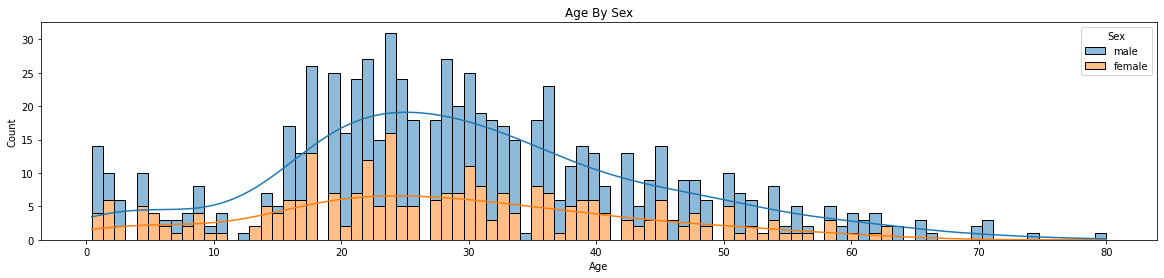

In [17]:
fig, ax1 = plt.subplots(1, 1,  figsize=(20,4))
sns.histplot(ax=ax1,data=titanic_df,x="Age", hue="Sex",multiple="stack",bins=90, kde=True)\
    .set(title="Age By Sex")

We can see in this dataset, male is more present than woman. let's check the survirval rate by age and by sex:

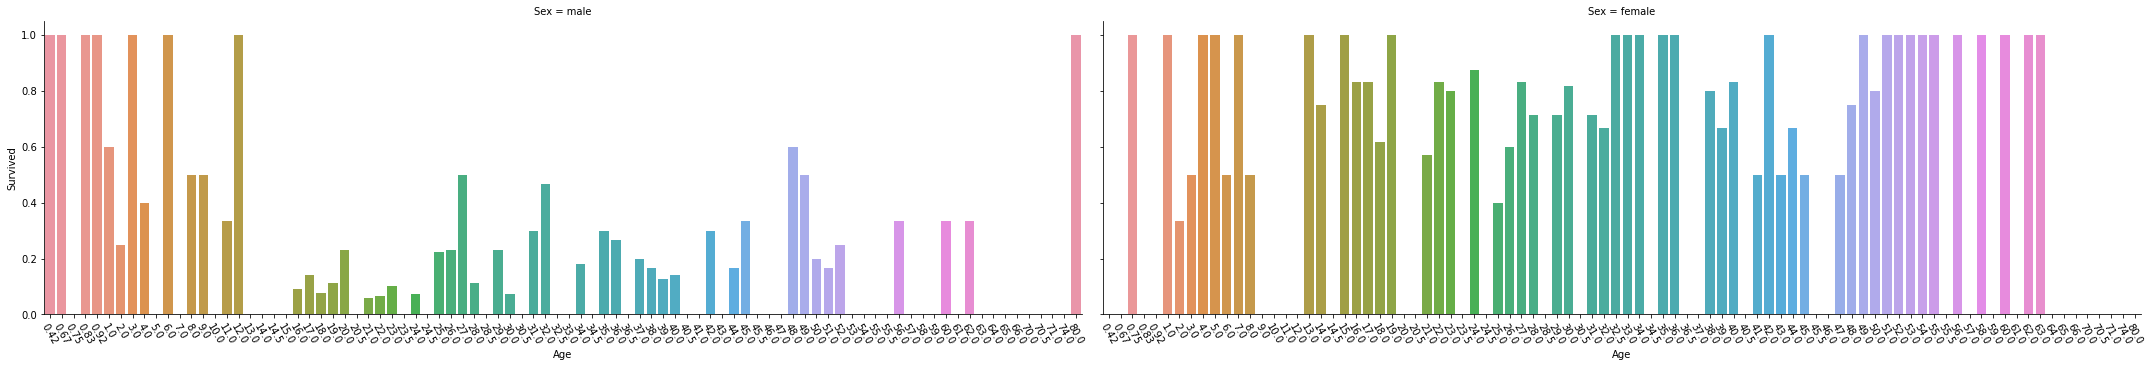

In [20]:
#Show the survival rate by ages and sex of the population
ax = sns.catplot(x="Age",y="Survived",col="Sex",data=titanic_df
    , kind="bar", ci=None, aspect=3)
#Rotate X labels for a better readability
for axes in ax.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)

The last graphics can tell us: 
1. Sex seems to be more related with people who survive or not
2. Woman as a higher survived rate independently of the age compared to men 
3. Old woman seems to survived every time ? 🤷🏽‍♀️ (Look like)
4. Maybe children (age < 14) as a better survived than adult 

We can try to create two news features: 
1. is_children for peoples with age <=14
2. after_fifty only for woman with ages >= 50

But now return to our problem the missing values 🎯

➡️ For this exploration i try to use the median of the age feature to fill nan value. 


In [22]:
# Fill nan value by the median of the age distribution
titanic_df["Age"] = titanic_df["Age"].fillna(titanic_df["Age"].median()).astype("int")

Off course, now we have 177 people with an age of 28 (the median). These peoples didn't enter in the news categories children and woman that i want to create

#### Work with Cabin feature



Also for Cabin, we have a lot of missing value, more than 50% of the dataset we can:
1. Drop the Cabin features 
2. Create two categories one for missing value on for existing value. Here we considering missing value as a category,using no information as an information.

Try the second strategy
   

In [23]:
# Convert Cabin in a binary problem
titanic_df["Cabin_binary"]=titanic_df.apply(lambda x: 0 if pd.isnull(x.Cabin)  else 1, axis=1)

In [24]:
#Check if it's ok
titanic_df[["Cabin_binary","Cabin"]].head(5)

,Cabin_binary,Cabin
0,0,NaN
1,1,C85
2,0,NaN
3,1,C123
4,0,NaN


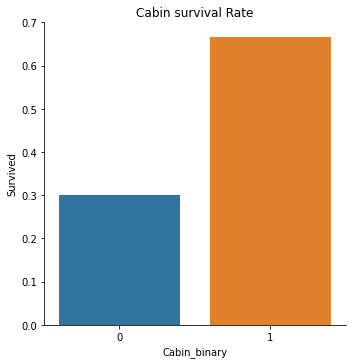

In [25]:
#Check the survived rate of people with Cabin information and without cabin information
ax = sns.catplot(x="Cabin_binary",y="Survived",data=titanic_df
    , kind="bar", ci=None, aspect=1).set(title="Cabin survival Rate")

In [26]:
# Get the importance of the Cabin_binary features for the prediction of  Survived 
titanic_df[["Survived","Cabin_binary"]].corr(method="pearson")

,Survived,Cabin_binary
Survived,1.000000,0.316912
Cabin_binary,0.316912,1.000000


With a good score of 31% we can say that the correlation it's important between this new feature and Survived column

In [27]:
#Drop Cabin column
titanic_df.drop("Cabin", inplace=True,axis=1)

#### Work with Embarked feature


In [28]:
#Count different value in Embarked features
titanic_df[["Embarked"]].value_counts()

Embarked
S           644
C           168
Q            77
dtype: int64

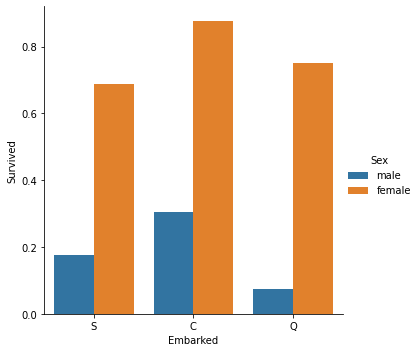

In [29]:
ax = sns.catplot(x="Embarked",y="Survived",hue="Sex",data=titanic_df
    , kind="bar", ci=None, aspect=1)

Dependent of the sex, we can see Embarked at C can give 10 to 15 % chance to survived compared to S and Q. Here for only 2 missings value we can drop these rows.


In [30]:
titanic_df = titanic_df[titanic_df['Embarked'].notna()]

### Features transformation

#### One Hot encoding categorical Data

We can see here that we have several categorical features:
- Survived > Binary class (0,1)
- Pclass > No Binary class (1,2,3)
- Sex > No Binary class (male, female) but easy to translate
- Maybe titles of names ? 
- Embarked > No Binary class (S, C, Q)
- Age maybe ? 

For this type of data we can use a one hot encoder to convert no binary class in multiple binary class.

> [Scikit Learn documentation about one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)


    

#### Convert Male female in binary class

In [ ]:
# Transform Sex features in sex_binary, 0 if it's a male 1 if it's female
titanic_df["sex_binary"] = titanic_df["Sex"].apply(lambda x: 0 if x == "male" else 1)

# Drop old Sex columns 
# titanic_df.drop(columns="Sex", inplace=True)

In [34]:
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_binary,sex_binary
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,1,1


#### Convert Pclass in binary class

In [35]:
# Declare an One Hot encoding object
ohe = OneHotEncoder(handle_unknown='ignore')
#Fit and transform on the Pclass features
encode_df = pd.DataFrame(ohe.fit_transform(titanic_df[["Pclass"]]).toarray())
#Get the columns names out of the news features (construct like names_of_old_features_className)
encode_df.columns = ohe.get_feature_names_out()
#Join news features with the titanic dataframe
titanic_df = titanic_df.join(encode_df)

#Drop old Pclass column
titanic_df.drop(columns="Pclass", inplace=True)

In [36]:
#Check news classes
titanic_df.head(2)

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_binary,sex_binary,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,0,0,0.0,0.0,1.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,1,1,1.0,0.0,0.0


it's work 🤟

#### Convert age feature in categories

Here we can see lot of things: 
1. Children (age <= 14) seems to have a significant higher survival rate
2. Women with an age superior at 50 seems to have a significant higher survival rate

We can try to create 3 class: 
1. One for children 
2. One for women with an age superior at 50
3. The others

It's a data exploration, after the first running model we can try to improve  our predict score by change the classes and features. 

In [37]:
#Define a class by age and sex
def class_of_people_by_age_sex(age, sex):
    if age<=12:
        return "Children"
    elif age>=50 and sex==1:
        return "female_a_50"
    else :
        return "middle"

In [38]:
#Create the three different classes of people
titanic_df["Who"] = titanic_df[["sex_binary","Age"]].apply(lambda x : class_of_people_by_age_sex(x.Age, x.sex_binary), axis = 1)


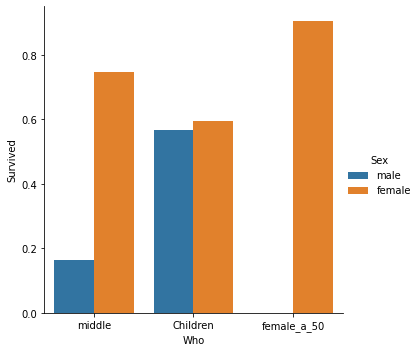

In [39]:
#Show the survival rate by new classes
ax = sns.catplot(x="Who",y="Survived",data=titanic_df
    , kind="bar",hue="Sex", ci=None, aspect=1)

In [40]:
#Create two news features for Children and female over 50
titanic_df["is_children"] = titanic_df["Age"].apply(lambda x: 0 if x>=14 else 1)
titanic_df["is_woman_over_50"] = titanic_df[["Age","sex_binary"]].apply(lambda x: 1 if x.Age>=50 and x.sex_binary == 1 else 0, axis=1)
titanic_df.drop(columns=["Age","Who"], inplace=True)

In [41]:
#Check these news features
titanic_df[titanic_df["is_woman_over_50"]==1].head(3)

,PassengerId,Survived,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,Cabin_binary,sex_binary,Pclass_1,Pclass_2,Pclass_3,is_children,is_woman_over_50
11,12,1,"Bonnell, Miss. Elizabeth",female,0,0,113783,26.5500,S,1,1,1.0,0.0,0.0,0,1
15,16,1,"Hewlett, Mrs. (Mary D Kingcome)",female,0,0,248706,16.0000,S,0,1,0.0,1.0,0.0,0,1
177,178,0,"Isham, Miss. Ann Elizabeth",female,0,0,PC 17595,28.7125,C,1,1,0.0,1.0,0.0,0,1


#### Convert Emarked in categories

In [42]:
# Declare an One Hot encoding object
ohe = OneHotEncoder(handle_unknown='ignore')
#Fit and transform on the Embarked features
encode_df = pd.DataFrame(ohe.fit_transform(titanic_df[["Embarked"]]).toarray())
#Get the columns names out of the news features (construct like names_of_old_features_className)
encode_df.columns = ohe.get_feature_names_out()
#Join news features with the titanic dataframe
titanic_df = titanic_df.join(encode_df)

#Drop old Embarked column
titanic_df.drop(columns="Embarked", inplace=True)

#### Check if the names of peoples contains good informations 👌🏼

We can see  in the names features different types of titles: 
- mrs
- mr
- etc

Does that titles contains any information ? 



In [44]:
#Get the title of a name (mrs, ms etc) thanks to regex 👌🏼
def get_title(user_name):
    return  re.search(r', (.+?\.)',user_name).group(1)


In [45]:
#Get name categories  
titanic_df["Name_cat"]= titanic_df["Name"].apply(lambda x : get_title(x))

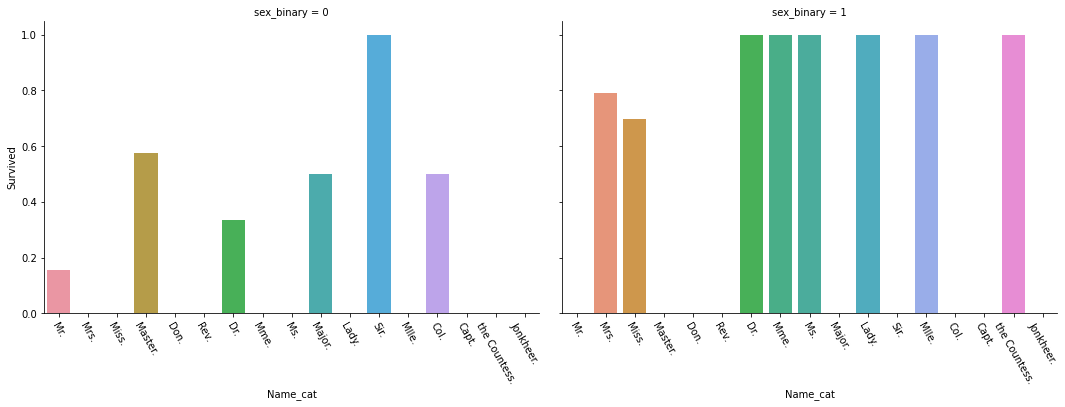

In [46]:
#Show the survival rate by Titles of peoples
ax = sns.catplot(x="Name_cat",y="Survived",col="sex_binary",data=titanic_df
    , kind="bar", ci=None, aspect=1.5)
#Rotate X labels for a better readability
for axes in ax.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)

Yes ✅ but we cannot create an infinite number of features and one hot encode this new feature can generate 16 new features by default. 
We can agregate :
- Dr. 
- Mme.
- Lady
- Mlle
- Col
- The Countess
- Sir 
In one class
Why ? Because it contains the same information in regards to survived rate. 


In [47]:
# Survival rate of 1
high_survival_rate = ["Sir.","Dr.","Mme.","Ms.","Lady.","Mlle.","the Countess."]
#Survival rate of 0.5
middle_survival_rate = ["Major.","Col."]

#Create new features
titanic_df["high_suvived_titles"] = titanic_df["Name_cat"].apply(lambda x: 1 if x in high_survival_rate else 0)
titanic_df["middle_suvived_titles"] = titanic_df["Name_cat"].apply(lambda x: 1 if x in middle_survival_rate else 0)

In [48]:
titanic_df[titanic_df["high_suvived_titles"]==1].head(2)

,PassengerId,Survived,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin_binary,sex_binary,...,Pclass_2,Pclass_3,is_children,is_woman_over_50,Embarked_C,Embarked_Q,Embarked_S,Name_cat,high_suvived_titles,middle_suvived_titles
245,246,0,"Minahan, Dr. William Edward",male,2,0,19928,90.0,1,0,...,0.0,1.0,0,0,0.0,0.0,1.0,Dr.,1,0
317,318,0,"Moraweck, Dr. Ernest",male,0,0,29011,14.0,0,0,...,0.0,0.0,0,0,0.0,0.0,1.0,Dr.,1,0


In [49]:
# Declare an One Hot encoding object
ohe = OneHotEncoder(handle_unknown='ignore')
#Fit and transform on the Name_cat features
encode_df = pd.DataFrame(ohe.fit_transform(titanic_df[["Name_cat"]]).toarray())
#Get the columns names out of the news features (construct like names_of_old_features_className)
encode_df.columns = ohe.get_feature_names_out()
#Join news features with the titanic dataframe
titanic_df = titanic_df.join(encode_df)

#Drop old Name_cat column
titanic_df.drop(columns="Name_cat", inplace=True)

In [50]:
# Delete already present information in high_suvived_titles and middle columns
good_name = ["Name_cat_"+title for title in high_survival_rate + middle_survival_rate]
titanic_df.drop(columns=good_name, inplace=True)

In [51]:
titanic_df.head(2)

,PassengerId,Survived,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin_binary,sex_binary,...,high_suvived_titles,middle_suvived_titles,Name_cat_Capt.,Name_cat_Don.,Name_cat_Jonkheer.,Name_cat_Master.,Name_cat_Miss.,Name_cat_Mr.,Name_cat_Mrs.,Name_cat_Rev.
0,1,0,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,1,1,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Target Class repartition

In [52]:
titanic_df[["Survived"]].value_counts()

Survived
0           549
1           340
dtype: int64

We can see here the target class is unbalance:

| Survived | 0   | 1   |
|----------|-----|-----|
|          | 549 | 342 |

But let's try an easy model to check if we have a good accuracy, with this unbalanc target Class. 

In [53]:
titanic_df.keys()

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin_binary', 'sex_binary', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'is_children', 'is_woman_over_50', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'high_suvived_titles',
       'middle_suvived_titles', 'Name_cat_Capt.', 'Name_cat_Don.',
       'Name_cat_Jonkheer.', 'Name_cat_Master.', 'Name_cat_Miss.',
       'Name_cat_Mr.', 'Name_cat_Mrs.', 'Name_cat_Rev.'],
      dtype='object')

In [54]:
titanic_2_df = titanic_df[["Survived","Fare","Cabin_binary","sex_binary","Pclass_1",\
    "Pclass_2","Pclass_3","high_suvived_titles", 'Name_cat_Don.', 'Name_cat_Jonkheer.',
       'Name_cat_Master.', 'Name_cat_Miss.', 'Name_cat_Mr.', 'Name_cat_Mrs.',
       'Name_cat_Rev.']].dropna().copy()

# Check the 0 value in the dataset
for column in titanic_2_df.columns:
    print(f"{column} as {(titanic_2_df[column]==0).sum()} 0 values")

Survived as 548 0 values
Fare as 15 0 values
Cabin_binary as 686 0 values
sex_binary as 575 0 values
Pclass_1 as 674 0 values
Pclass_2 as 704 0 values
Pclass_3 as 396 0 values
high_suvived_titles as 873 0 values
Name_cat_Don. as 886 0 values
Name_cat_Jonkheer. as 886 0 values
Name_cat_Master. as 848 0 values
Name_cat_Miss. as 706 0 values
Name_cat_Mr. as 371 0 values
Name_cat_Mrs. as 763 0 values
Name_cat_Rev. as 881 0 values


### Check numerical continuous value and apply scaling

<AxesSubplot:>

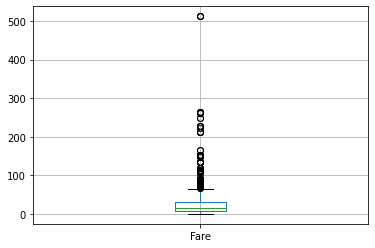

In [55]:
#Check if fare have outliers
titanic_2_df[["Fare"]].boxplot()

Ok, with Fare we have a lot of outsider. Go to a robustScaling. (After train test our dataset)
With the help of the learning curve, we can find a good estimation for our split percentage. 

In [57]:
#Get all columns execpt Survived
X = titanic_2_df.loc[:,titanic_2_df.columns != "Survived"]
#Select the target features
y= titanic_2_df["Survived"]
#Cut the dataset in 50% test 50% train
X_train, X_test, y_train, y_test = train_test_split(\
       X, y, test_size=0.50, random_state=4011)

<AxesSubplot:>

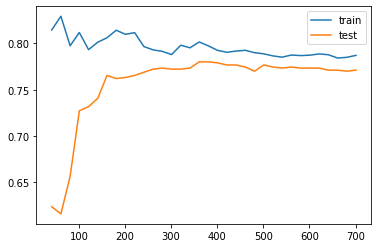

In [63]:
train_sizes, train_scores, test_scores = learning_curve(
     LogisticRegression(solver = "liblinear",max_iter=500 ), X, y, train_sizes=[i for i in range(1,709,20)], cv=5)

train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
sns.lineplot(train_sizes, train_scores_mean, label="train")
sns.lineplot(train_sizes, test_scores_mean, label="test")

In [65]:
#Define our X
X = titanic_2_df.loc[:,titanic_2_df.columns != "Survived"]

#Define our Y
y= titanic_2_df["Survived"]

This last curves can tell us than 350~400 rows in our train dataset is enough.

In [79]:
#Get all columns execpt Survived
X = titanic_2_df.loc[:,titanic_2_df.columns != "Survived"]
#Select the target features
y= titanic_2_df["Survived"]
#Cut the dataset in 40% test 60% train
X_train, X_test, y_train, y_test = train_test_split(\
       X, y, test_size=0.40, random_state=4011)

In [80]:

# For outlier
r_scaler = RobustScaler()

scaler_robust= r_scaler.fit(X_train[["Fare"]])
X_train[["Fare"]] = scaler_robust.transform(X_train[["Fare"]])
X_test[["Fare"]] =scaler_robust.transform(X_test[["Fare"]])



### Test a dummy logistic regression model

In [81]:
model = LogisticRegression(max_iter=1000, solver="liblinear")
cv_results = cross_validate(model, X_train,y_train,cv=5)
result = cv_results["test_score"].mean()
print(f"resultat de la moyenne des cross validation : {result}")


resultat de la moyenne des cross validation : 0.8176864750484925


In [ ]:
# # Fine tune with random state
#res = []
#for i in range(0,10000):
#    X_train, X_test, y_train, y_test = train_test_split(\
#        X, y, test_size=0.40, random_state=i)
#    model = LogisticRegression(max_iter=1000, solver="liblinear")
#    res.append(cross_validate(model, X_train,y_train,cv=5)["test_score"].mean())
#    print(f"resultat de la moyenne des cross validation : {result}, pour un random state de {i+1}")


In [ ]:
# max(res)

## Fine tune LR and try other binary classifier (In Progress 🎯)

#### Robust scaling on Fare

In [ ]:
titanic_2_df[:10]

How we cut the dataset in train test split ? 

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
...     SVC(kernel='linear'), X, y, train_sizes=[50, 80, 110], cv=5)

In [ ]:
X = titanic_2_df.loc[:, titanic_2_df.columns != "Survived"]
y = titanic_2_df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# For outlier
r_scaler = RobustScaler()

s_scaler = StandardScaler()

mean_of_train_age = X_train.Age.mean()
X_train.Age.fillna(mean_of_train_age, inplace=True)
X_test.Age.fillna(mean_of_train_age, inplace=True)

scaler = s_scaler.fit(X_train[["Age","SibSp","Parch"]])
X_train[["Age","SibSp","Parch"]] = scaler.transform(X_train[["Age","SibSp","Parch"]])
X_test[["Age","SibSp","Parch"]] =scaler.transform(X_test[["Age","SibSp","Parch"]])

scaler_robust= r_scaler.fit(X_train[["Fare"]])
X_train[["Fare"]] = scaler_robust.transform(X_train[["Fare"]])
X_test[["Fare"]] =scaler_robust.transform(X_test[["Fare"]])



In [ ]:
X_train

In [ ]:
dataplot = sns.heatmap(X_train.corr(), cmap="YlGnBu", annot=True)

In [ ]:
model = LogisticRegression()
cv_results = cross_validate(model, X_train,y_train,cv=5)
result = cv_results["test_score"].mean()
print(f"resultat de la moyenne des cross validation : {result}")

In [ ]:
train_sizes = [1,25,50,100,150,200,300,400,500,712]
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticRegression(max_iter=1000),X=X,y=y,\
                train_sizes=train_sizes, cv=10)
train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
sns.lineplot(train_sizes, train_scores_mean, label="train")
sns.lineplot(train_sizes, test_scores_mean, label="test")

#### Check deep learning to predict class survived or not

In [ ]:
# Tensorflow for machine learning
# import tensorflow as tf
import swifter
# Numpy and pandas for dataset manipulation
import numpy as np
import pandas as pd
#Seaborn and matplotlib to make graphics 
import seaborn as sns
import matplotlib.pyplot as plt

#Skelarn metrics to get confusion matrix and classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Shuffle sklearn lib to  mixing train dataset X and y
from sklearn.utils import shuffle

In [ ]:
def plot_get_conf_learning(model,history, X_test, y_test ):
    
    # Predict class for X_test
    predictions = model.predict(X_test)
    # Affect class
    y_mean_pred = [1 * (x[0]>=0.5) for x in predictions]
    # Create confusion matrix
    cf_matrix = confusion_matrix( y_test, y_mean_pred)

    #Create subplot
    fig, axes = plt.subplots(1, 2,  figsize=(15,4))

    # Confusion matrix plotting
    axes[0].set_title(' Confusion Matrix with labels\n\n');
    sns.heatmap(ax =axes[0], data = cf_matrix, annot=True, cmap='Reds')


    # Learning curves plotting
    loss = history.history["loss"]
    loss_val = history.history["val_loss"]
    sns.lineplot(ax=axes[1],data =[loss,loss_val])
    axes[1].set_title('Learning curves \n\n')
    axes[1].legend(labels=["Train set","Test set"], title = "Learning curves")
    
    #Print classification report
    print(classification_report(y_test, y_mean_pred))
    #Show graphics
    return plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import RMSprop

def init_model():
    # opt = RMSprop(lr=0.0001, decay=1e-6)
    model = models.Sequential()
    neurons = 8
    model.add(layers.Dense(4, activation='linear'))
    model.add(layers.Dropout(0.01))
    model.add(layers.Dense(4, activation='linear', kernel_regularizer='l1'))
    model.add(layers.Dropout(0.01))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer="adam", 
                  metrics=['accuracy'])
    return model

In [ ]:
# Impor tensorflow early stopping callback to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

# Define the mode@l
model_mean_v1 = init_model()
#Define early stopping parmaters
es = EarlyStopping(patience=600, restore_best_weights=True,monitor='val_loss')

#Start training the neural network
history_mean_v1 = model_mean_v1.fit(X_train, y_train, 
          epochs=2000, 
          batch_size=1, 
          verbose=1, 
          callbacks=es,
          validation_split=0.15)

In [ ]:
plot_get_conf_learning(model_mean_v1,history_mean_v1,X_test, y_test)

In [ ]:
X_train

## Decision tree classifier model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=2)
tree_clf.fit(X_train,y_train)
tree_clf.score(X_test, y_test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=42, learning_rate=1,
     max_depth=2, random_state=4
     ).fit(X_train, y_train)
clf.score(X_test, y_test)


In [ ]:
from sklearn.linear_model import SGDClassifier
svc_bis = SGDClassifier(loss='hinge', penalty='l2')
svc_bis.fit(X_train, y_train)
svc_bis.score(X_test, y_test)

In [ ]:
0.8483108440854921
{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 42}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Train/Test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Instanciate model
model = GradientBoostingClassifier()
# Hyperparameter Grid
n_estimators = [i for i  in range(2,50,5)]
max_depth =[i for i  in range(2,50,5)]

grid = {'n_estimators': n_estimators, 
        'learning_rate': [0.1,0.3,0.5,0.8,1,2],
        'max_depth':max_depth
        }

# Instanciate Grid Search
search = GridSearchCV(model, grid, 
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          ) 

# Fit data to Grid Search
search.fit(X_train,y_train);

In [ ]:
# Best score
print(search.best_score_)

# Best Params
print(search.best_params_)

# Best estimator
print(search.best_estimator_)